In [2]:
#use niwrap3912 for conda environment
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import yaspy
import scipy
import pyvista as pv
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import brainspace.gradient.alignment as ga
# Project-specific imports
import sys
import os
# Use the current working directory as reference since __file__ is not defined in a notebook
gradient_utils_path = os.path.abspath(os.path.join(os.getcwd(), '../092325_cortical_gradients'))
if gradient_utils_path not in sys.path:
    sys.path.append(gradient_utils_path)
from gradient_utils import *

global PARCELLATION_METHOD
do_parcellation = True
PARCELLATION_METHOD = 'MEAN'#from the workbench parcellation result COV is coefficient of variation
add_bigbrain_data = True
normalize_data = False#when set true, it will normalize the data to z-score for the total, supra and infra layers

BASEPATH = "/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server/"
hcp_thickness_path = f'{BASEPATH}/data/thickness_data/hcp/'
exvivo_thickness_path=f'{BASEPATH}/data/thickness_data/exvivo_final/'
#Schaefer 400 parcelation
atlas_path = f'{BASEPATH}/parcellation/Schaefer/Schaefer2018_400Parcels_7Networks_order.dlabel.nii'
atlas = nib.load(atlas_path).get_fdata()[0].astype(int)

atlas_macaque_path = f'{BASEPATH}/parcellation/Schaefer-macaque/L.Schaefer2018_400Parcels_7Networks_order.human-to-monkey.32k_fs_LR.label.gii'
atlas_macaque_lh = nib.load(atlas_macaque_path).darrays[0].data


#Economo Koskinas atlas (left and right are pretty much symmetrical*)
#atlas_path_L = '/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/layer_project/cortical_layer/external/economo_enigamtoolbox/economo_koskinas_conte69_from_enigmatoolbox_32k_fs_L.func.gii'
#atlas_path_R = '/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/layer_project/cortical_layer/external/economo_enigamtoolbox/economo_koskinas_conte69_from_enigmatoolbox_32k_fs_R.func.gii'

#for more detailed parcellation, use von ek atlas
#myatlas_base_path = "/Users/dennis.jungchildmind.org/Downloads/MYATLAS_package_new/"
#von_ek_subpath = "maps/Surface/HCP_conte69/conte69_32k/gii/cytoarchitecture/"
#atlas_path_L = os.path.join(myatlas_base_path, von_ek_subpath,'vonEK_parcellation_from_myatls_conte69_32k_lh.func.gii')
#atlas_L = nib.load(atlas_path_L).darrays[0].data
#atlas = np.tile(atlas_L, 2).astype(int)  # duplicate for both hemispheres and convert to int

#data directory
baseDir = f'{BASEPATH}/data/thickness_data/exvivo_final'
baseDir_bigbrain = f'{BASEPATH}/data/thickness_data/BigBrain/thickness/resample/'
subject_dirs = [d for d in os.listdir(baseDir) if os.path.isdir(os.path.join(baseDir, d))]

#load atlas
#https://github.com/ThomasYeoLab/CBIG/blob/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/HCP/fslr32k/cifti/Schaefer2018_200Parcels_7Networks_order.dscalar.nii
atlas_path = f'{BASEPATH}/parcellation/Schaefer/Schaefer2018_400Parcels_7Networks_order.dlabel.nii'
atlas = nib.load(atlas_path).get_fdata()[0].astype(int)
#split atlas into left and right hemispheres for later use       
atlas_data_lh = atlas[:len(atlas)//2]
atlas_data_rh = atlas[len(atlas)//2:]
atlas_data_rh = atlas_data_rh - np.min(atlas_data_rh[atlas_data_rh != 0])+1
atlas_data_rh[atlas_data_rh <= 0] = 0
num_parcels = int(atlas_path.split('_')[1].split('Parcels')[0])  # Extract number of parcels from atlas path



pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [3]:
'''
def parcellate_data(matrix, atlas, hemisphere):
    """Parcellate cortical layer data using a given atlas."""
    # Load atlas
    parcelIndices = atlas
    max_parcel_ind = int(np.max(parcelIndices))
    
   
    if max_parcel_ind == 100 or max_parcel_ind == 200 or max_parcel_ind == 400 or max_parcel_ind == 1000:
        #if Schaefer parcellation
        m = int(max_parcel_ind/2)+1
    elif max_parcel_ind == 180:
        #if Glasser parcellation
        m = 180 + 1
    elif max_parcel_ind == 35:
        #if Desikan parcellation
        m = 35 + 1
    else: 
        raise ValueError(f"Unsupported parcellation with {max_parcel_ind} parcels")
        
    # Split indices by hemisphere
    if hemisphere == 'lh':
        parcelIndices = parcelIndices[0:32492]
    elif hemisphere == 'rh':
        parcelIndices = parcelIndices[32492:]
    
    # Initialize output array
    parcellated = []
    
    # Parcellate data for each subject
    for subject_idx in range(matrix.shape[0]):
        
        #m = int(max_parcel_ind/2)+1
        #m = 180+1 #for glasser or deikan (35)
       # m = 35+1;#desikan
        # Initialize array for this hemisphere's parcels
        subject_data = np.zeros(m)
        
        # Get subject's data
        data = matrix[subject_idx]
        
        # Set parcel range based on hemisphere
        if hemisphere == 'lh':
            parcel_range = range(0, m)
            print(parcel_range)
        elif hemisphere == 'rh':
            parcel_range = list(range(m, max_parcel_ind+1))
            parcel_range.insert(0, 0)
            print(parcel_range)

            if max_parcel_ind == 180 or max_parcel_ind == 35:
                parcel_range = range(1,m) #for glasser or deikan
            
            
        # Calculate mean for each parcel
        for k in parcel_range:
            mask = parcelIndices == k
            if np.sum(mask) > 0:
                
                if max_parcel_ind == 180 or max_parcel_ind == 35:
                    parcel_idx = k #parcel_idx = k  #for glasser or deikan
                else:
                    parcel_idx = k if hemisphere == 'lh' else k-m+1
                
                #instead of trimmed mean, calculates mean and standard deviation and remove anything above 2 standard deviations
                mean = np.mean(data[mask][~np.isnan(data[mask])])
                std = np.std(data[mask][~np.isnan(data[mask])])
                subject_data[parcel_idx] = np.mean(data[mask][data[mask] < mean + 2*std])
                
                # This uses trimmed mean with 10% trim on both ends
                # Science advances paper, "structural covariance, Parcellation Approach in Methods"
                #subject_data[parcel_idx] = scipy.stats.trim_mean(data[mask][~np.isnan(data[mask])], proportiontocut=0.1)
                
                
        # Append subject's parcellated data
        parcellated.append(subject_data)
            
    # Convert list to numpy array
    return np.vstack(parcellated)



def process_hemisphere_data(data, atlas, hemi):
    """
    Process hemisphere data by parcellating metrics and calculating derived measures
    
    Parameters:
    -----------
    data : dict
        Dictionary containing hemisphere data with metrics like 'total', 'infra', etc
    atlas : array-like
        Atlas data for parcellation
    hemi: str, 'lh' or 'rh'
    Returns:
    --------
    dict : Processed and parcellated data
    """
    # Initialize output dictionary
    data_parc = {
        'total': [], 'infra': [], 'supra': [], 'relative': [], 'ratio_supra': [], 'ratio_infra': [], 'diff': []
    }

    # Parcellate basic metrics
    for metric in ['total', 'infra', 'supra', 'diff']:
      
        data_parc[metric] = parcellate_data(data[metric].T, atlas, hemi).T
        

    # Calculate relative and ratio metrics
    data_parc['relative'] = data_parc['supra'] / data_parc['infra']
    data_parc['ratio_supra'] = data_parc['supra'] / data_parc['total']
    data_parc['ratio_infra'] = data_parc['infra'] / data_parc['total']

    #then normalize every key in the data_parc
    if normalize_data:
        for metric in ['total','infra','supra']:
            #data is 32492 x samples so zscore should run axis = 0
            data_parc[metric]= np.nan_to_num(scipy.stats.zscore(data_parc[metric], axis=0, nan_policy='omit'))
      

    # Clean up invalid values
    for metric in ['relative', 'ratio_supra', 'ratio_infra']:
        data_parc[metric][data_parc[metric] == np.inf] = 0
        data_parc[metric][data_parc[metric] == np.nan] = 0

    return data_parc



def process_hemisphere_parcellation(lh_data_parc=None, rh_data_parc=None, atlas=None):
    """
    Process left and right hemisphere parcellation data using an atlas
    
    Parameters:
    -----------
    lh_data_parc : dict
        Left hemisphere parcellation data
    rh_data_parc : dict 
        Right hemisphere parcellation data
    atlas : array-like
        Atlas data for mapping
        
    Returns:
    --------
    tuple : Processed left and right hemisphere data
    """
    # Initialize dictionary with empty arrays only for keys that exist in input data
    lh_data_parc_new = {}
    if lh_data_parc is not None:
        for key in lh_data_parc.keys():
            # Initialize with correct shape based on input data
            n_vertices = 32492
            n_samples = lh_data_parc[key].shape[1]
            lh_data_parc_new[key] = np.zeros((n_vertices, n_samples))
    
    if lh_data_parc is not None:
        # Process left hemisphere data
        for key in lh_data_parc.keys():
            for i in range((lh_data_parc[key].shape[1])):
                mask_lh = atlas[:32492] != 0
                min_atlas = np.min(atlas[:32492][atlas[:32492] != 0])
                max_atlas = np.max(atlas[:32492][atlas[:32492] != 0])
                lh_data_parc_new[key][:,i] = map_to_labels(lh_data_parc[key][1:,i].ravel(), atlas[:32492], 
                                                mask=mask_lh, fill=np.nan,
                                                source_lab=np.arange(min_atlas, max_atlas+1))
   
    rh_data_parc_new = {}
    if rh_data_parc is not None:
        for key in rh_data_parc.keys():
            n_vertices = 32492
            n_samples = rh_data_parc[key].shape[1]
            rh_data_parc_new[key] = np.zeros((n_vertices, n_samples))

    if rh_data_parc is not None:
    # Process right hemisphere data 
        for key in rh_data_parc.keys():
            for i in range((rh_data_parc[key].shape[1])):
                mask_rh = atlas[32492:] != 0
                min_atlas = np.min(atlas[32492:][atlas[32492:] != 0])
                max_atlas = np.max(atlas[32492:][atlas[32492:] != 0])
                rh_data_parc_new[key][:,i] = map_to_labels(rh_data_parc[key][1:,i].ravel(), atlas[32492:],
                                                mask=mask_rh, fill=np.nan,
                                                source_lab=np.arange(min_atlas, max_atlas+1))
        
    
    lh_data_parc = lh_data_parc_new
    rh_data_parc = rh_data_parc_new
    return lh_data_parc, rh_data_parc
'''

'\ndef parcellate_data(matrix, atlas, hemisphere):\n    """Parcellate cortical layer data using a given atlas."""\n    # Load atlas\n    parcelIndices = atlas\n    max_parcel_ind = int(np.max(parcelIndices))\n\n\n    if max_parcel_ind == 100 or max_parcel_ind == 200 or max_parcel_ind == 400 or max_parcel_ind == 1000:\n        #if Schaefer parcellation\n        m = int(max_parcel_ind/2)+1\n    elif max_parcel_ind == 180:\n        #if Glasser parcellation\n        m = 180 + 1\n    elif max_parcel_ind == 35:\n        #if Desikan parcellation\n        m = 35 + 1\n    else: \n        raise ValueError(f"Unsupported parcellation with {max_parcel_ind} parcels")\n\n    # Split indices by hemisphere\n    if hemisphere == \'lh\':\n        parcelIndices = parcelIndices[0:32492]\n    elif hemisphere == \'rh\':\n        parcelIndices = parcelIndices[32492:]\n\n    # Initialize output array\n    parcellated = []\n\n    # Parcellate data for each subject\n    for subject_idx in range(matrix.shape[0]):

In [4]:
# NOTE: LOAD THICKNESS DATA AND PREPARE DATA FOR ANALYSIS

lh_data_parc = []
rh_data_parc = []

# --- Analysis Loop for Ex Vivo data only ---
baseDir = exvivo_thickness_path
data_types = ['total', 'infra', 'supra', 'relative', 'ratio_supra']

hemispheres = {'lh': 'left', 'rh': 'right'}

# Get all subject directories in the baseDir
subject_dirs = [d for d in os.listdir(baseDir) if os.path.isdir(os.path.join(baseDir, d))]

# Initialize data dictionary for every hemisphere and type
data = {hemi: {dtype: [] for dtype in data_types} for hemi in hemispheres}

# Helper lists to keep track of included subject names
lh_subjects, rh_subjects = [], []
lh_subjects_name, rh_subjects_name = [], []

# -------- Data Loading --------
for subjectDir in subject_dirs:
    for hemi in hemispheres:
        # Construct appropriate file path
        surf_file = f'{baseDir}{subjectDir}/{hemi}.pial.32k_fs_LR.surf.gii'

        if os.path.exists(surf_file):
            # Update subject lists
            if hemi == 'lh':
                lh_subjects.append(subjectDir)
                lh_subjects_name.append(subjectDir.replace('_new_confidence', ''))
            else:
                rh_subjects.append(subjectDir)
                rh_subjects_name.append(subjectDir.replace('_new_confidence', ''))

            # Suffix is consistent for both
            suffix = '6mm'  # By default, use "6mm". Other option is None for no smoothing
            # Load and process thickness data for subject and hemisphere
            thickness_data = load_thickness_exvivo_data(baseDir, subjectDir, hemi, suffix)
            thickness_data.update(calculate_derived_measurements(thickness_data))  # this calculates relative, ratio_supra, ratio_infra, and diff

            # Store data for each type efficiently using numpy
            for dtype in data_types:
                reshaped = thickness_data[dtype].reshape(-1, 1)
                if len(data[hemi][dtype]) > 0:
                    data[hemi][dtype] = np.concatenate((data[hemi][dtype], reshaped), axis=1)
                else:
                    data[hemi][dtype] = reshaped

# -------- BigBrain Data (ex vivo only) --------
if add_bigbrain_data:
    for hemi in hemispheres:
        thickness_data = load_thickness_bigbrain_data(baseDir_bigbrain, hemi)
        thickness_data.update(calculate_derived_measurements(thickness_data))
        for dtype in data_types:
            reshaped = thickness_data[dtype].reshape(-1, 1)
            if len(data[hemi][dtype]) > 0:
                data[hemi][dtype] = np.concatenate((data[hemi][dtype], reshaped), axis=1)
            else:
                data[hemi][dtype] = reshaped
    lh_subjects_name.append('bigbrain')
    rh_subjects_name.append('bigbrain')

# -------- Parcellation if specified --------
if do_parcellation:
    for hemi in hemispheres:
        # Choose the appropriate atlas_data for each hemisphere
        atlas_data = atlas_data_lh if hemi == 'lh' else atlas_data_rh
        for dtype in data_types:
            print('hemi', hemi, 'dtype', dtype)
            tmp_data = []
            for i in range(data[hemi][dtype].shape[1]):
                print('i', i)
                parcellated = parcellate_data(data[hemi][dtype][:, i], atlas_data)
                tmp_data.append(parcellated)
            data[hemi][dtype] = np.array(tmp_data).T

# -------- Assemble Final Data --------
lh_data_parc = data['lh']
rh_data_parc = data['rh']


hemi lh dtype total
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
hemi lh dtype infra
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
hemi lh dtype supra
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
hemi lh dtype relative
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
hemi lh dtype ratio_supra
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
hemi rh dtype total
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
hemi rh dtype infra
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
hemi rh dtype supra
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
hemi rh dtype relative
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
hemi rh dtype ratio_supra
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8


In [5]:
'''
data_types = ['total','infra', 'supra', 'relative', 'ratio_supra', 'ratio_infra']
hemispheres = {'lh': 'left', 'rh': 'right'}


# Initialize data dictionary with nested structure for hemispheres and data types
data = {hemi: {dtype: [] for dtype in data_types} for hemi in hemispheres}

def clean_thickness_data(data_array):
    """Clean NaN and Inf values from array using masked arrays."""
    masked_array = np.ma.masked_invalid(data_array)
    return np.array(masked_array.filled(0))

def load_thickness_exvivo_data(base_dir, subject_dir, hemi, suffix):
    """Load thickness measurements for a given subject and hemisphere"""
    return {
        'total': nib.load(f'{base_dir}{subject_dir}/{hemi}.thickness.{suffix}.Schaefer2018_400Parcels.{PARCELLATION_METHOD}.pscalar.nii').get_fdata()[0],
        'infra': nib.load(f'{base_dir}{subject_dir}/{hemi}.thickness.wm.inf.{suffix}.Schaefer2018_400Parcels.{PARCELLATION_METHOD}.pscalar.nii').get_fdata()[0],
        'supra': nib.load(f'{base_dir}{subject_dir}/{hemi}.thickness.inf.pial.{suffix}.Schaefer2018_400Parcels.{PARCELLATION_METHOD}.pscalar.nii').get_fdata()[0],
    
    }

def load_thickness_bigbrain_data(base_dir, hemi):
    """Load thickness measurements for a given subject and hemisphere"""
    return {
        'total': nib.load(f'{base_dir}/{hemi}.0-6.32k._6mm_fwhm.Schaefer2018_400Parcels.{PARCELLATION_METHOD}.pscalar.nii').get_fdata()[0],#all layers
        'infra': nib.load(f'{base_dir}/{hemi}.3-6.32k._6mm_fwhm.Schaefer2018_400Parcels.{PARCELLATION_METHOD}.pscalar.nii').get_fdata()[0],#layers 4,5,6 (ex vivo style)
        'supra': nib.load(f'{base_dir}/{hemi}.0-3.32k._6mm_fwhm.Schaefer2018_400Parcels.{PARCELLATION_METHOD}.pscalar.nii').get_fdata()[0],#layers 1,2,3

    }

def load_thickness_macaque_exvivo_data(base_dir, hemi):
    """Load thickness measurements for a given subject and hemisphere"""
    return {
        'total': np.load(f'{base_dir}/lh_data_parc_macaque_schaefer400.npz')['total'],
        'infra': np.load(f'{base_dir}/lh_data_parc_macaque_schaefer400.npz')['infra'],#layers 4,5,6 (ex vivo style)
        'supra': np.load(f'{base_dir}/lh_data_parc_macaque_schaefer400.npz')['supra'],#layers 1,2,3

    }

def calculate_derived_measurements(thickness_data):
    """Calculate derived thickness measurements"""
    return {
        'relative': clean_thickness_data(np.divide(thickness_data['supra'], thickness_data['infra'], out=np.zeros_like(thickness_data['supra']), where=thickness_data['infra']!=0)),
        'ratio_supra': clean_thickness_data(np.divide(thickness_data['supra'], (thickness_data['supra']+thickness_data['infra']), out=np.zeros_like(thickness_data['supra']), where=thickness_data['infra']!=0)),
        'ratio_infra': clean_thickness_data(np.divide(thickness_data['infra'], (thickness_data['supra']+thickness_data['infra']), out=np.zeros_like(thickness_data['infra']), where=thickness_data['infra']!=0)),
    }

#save list of subjects of lh and rh separately
lh_subjects = []
rh_subjects = []
lh_subjects_name = []
rh_subjects_name = []

for subjectDir in subject_dirs:
    for hemi in hemispheres:
       
        surf_file = f'{baseDir}{subjectDir}/{hemi}.pial.32k_fs_LR.surf.gii'
        if os.path.exists(surf_file):
            if hemi == 'lh':
                lh_subjects.append(subjectDir)
                lh_subjects_name.append(subjectDir.replace('_new_confidence', ''))
            else:
                rh_subjects.append(subjectDir)
                rh_subjects_name.append(subjectDir.replace('_new_confidence', ''))

            #suffix = '32k_fs_LR'
            #suffix = '32k_6mm_fwhm_fs_LR'
            suffix = f'32k_6mm_fwhm_fs_LR'
            # Load and process thickness data
            thickness_data = load_thickness_exvivo_data(baseDir, subjectDir, hemi, suffix)
            #if coefficient of variation, multiply by 100 092625 DJ
            if PARCELLATION_METHOD == 'COV':
                for key in thickness_data:
                    thickness_data[key] = thickness_data[key] * 100
            thickness_data.update(calculate_derived_measurements(thickness_data))
            
            # Store data for each type more efficiently using numpy operations
            for dtype in data_types:
                reshaped = thickness_data[dtype].reshape(-1, 1)
                data[hemi][dtype] = np.concatenate((data[hemi][dtype], reshaped), axis=1) if len(data[hemi][dtype]) > 0 else reshaped

#and then, add the bigbrain data

if add_bigbrain_data:
    #
    print('?)')
    for hemi in hemispheres:
        thickness_data = load_thickness_bigbrain_data(baseDir_bigbrain, hemi)
        #if coefficient of variation, multiply by 100 092625 DJ
        if PARCELLATION_METHOD == 'COV':
            for key in thickness_data:
                thickness_data[key] = thickness_data[key] * 100

        thickness_data.update(calculate_derived_measurements(thickness_data))
        print(thickness_data['infra'].shape)
        for dtype in data_types:
         
            reshaped = thickness_data[dtype].reshape(-1, 1)
            data[hemi][dtype] = np.concatenate((data[hemi][dtype], reshaped), axis=1) if len(data[hemi][dtype]) > 0 else reshaped
    lh_subjects_name.append('bigbrain')
    rh_subjects_name.append('bigbrain')

#add macaque data
baseDir_macaque = '/Users/dennis.jungchildmind.org/Desktop/thomas-macaquedat/data'
add_macaque_data = True
if add_macaque_data:
    #macaque has left hemisphere only (120825 DJ)
    thickness_data = load_thickness_macaque_exvivo_data(baseDir_macaque, 'lh')
    #for each key just duplicate so that the data lengh is from 200 to 400
    for key in thickness_data:
        thickness_data[key] = np.concatenate((thickness_data[key], thickness_data[key]))
    thickness_data.update(calculate_derived_measurements(thickness_data))
    for dtype in data_types:
        reshaped = thickness_data[dtype].reshape(-1, 1)
        data['lh'][dtype] = np.concatenate((data['lh'][dtype], reshaped), axis=1) if len(data['lh'][dtype]) > 0 else reshaped
    lh_subjects_name.append('macaque')


lh_subjects = [subject.replace('_new_confidence', '') for subject in lh_subjects]
print(lh_subjects)

rh_subjects = [subject.replace('_new_confidence', '') for subject in rh_subjects]
print(rh_subjects)
'''

'\ndata_types = [\'total\',\'infra\', \'supra\', \'relative\', \'ratio_supra\', \'ratio_infra\']\nhemispheres = {\'lh\': \'left\', \'rh\': \'right\'}\n\n\n# Initialize data dictionary with nested structure for hemispheres and data types\ndata = {hemi: {dtype: [] for dtype in data_types} for hemi in hemispheres}\n\ndef clean_thickness_data(data_array):\n    """Clean NaN and Inf values from array using masked arrays."""\n    masked_array = np.ma.masked_invalid(data_array)\n    return np.array(masked_array.filled(0))\n\ndef load_thickness_exvivo_data(base_dir, subject_dir, hemi, suffix):\n    """Load thickness measurements for a given subject and hemisphere"""\n    return {\n        \'total\': nib.load(f\'{base_dir}{subject_dir}/{hemi}.thickness.{suffix}.Schaefer2018_400Parcels.{PARCELLATION_METHOD}.pscalar.nii\').get_fdata()[0],\n        \'infra\': nib.load(f\'{base_dir}{subject_dir}/{hemi}.thickness.wm.inf.{suffix}.Schaefer2018_400Parcels.{PARCELLATION_METHOD}.pscalar.nii\').get_fdata()

In [6]:
print(data['lh']['infra'].shape)

(200, 15)


(200, 15)
(200, 15)
(200, 15)
(200, 15)
(200, 15)


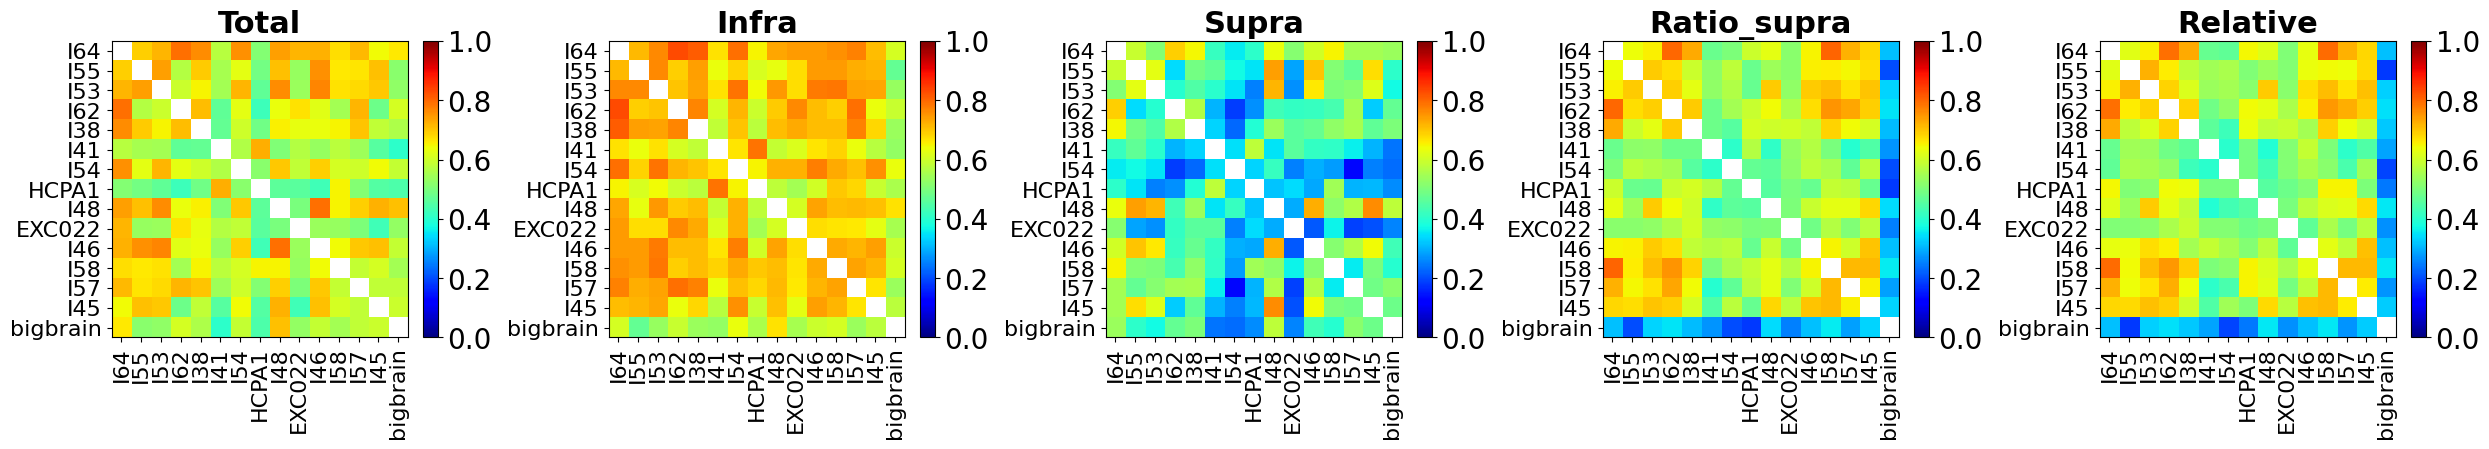

In [7]:
#now plot similarity matrix for each layer type
from mpl_toolkits.axes_grid1 import make_axes_locatable

plot_hemi = 'lh'
surf2plot = []
data2plot = data[plot_hemi]
LAYER_TYPES = ['total', 'infra', 'supra','ratio_supra','relative']
fig, axes = plt.subplots(1, len(LAYER_TYPES), figsize=(5*len(LAYER_TYPES), 5))
for i, key in enumerate(LAYER_TYPES):
    tmp_dat = data2plot[key]
    #remove any row that contains either zero or nan
    tmp_dat = tmp_dat[~np.isnan(tmp_dat).any(axis=1)]
    
    print(tmp_dat.shape)
    #only for Schaefer 400
    '''
    if plot_hemi == 'lh':
        if key == 'total':
            tmp_dat = tmp_dat[:200,:]
        elif key == 'infra':
            tmp_dat = tmp_dat[200:,:]
    '''
    #select only the first 
    #set nan values to 0
    corr_mat = np.corrcoef(tmp_dat.T)
    #set diagonal to 0
    corr_mat[np.eye(corr_mat.shape[0]) == 1] = np.nan
    #plot the corr_mat as a heatmap
    im = axes[i].imshow(corr_mat, cmap='jet', vmin=0,vmax=1)
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=20)
    axes[i].set_title(key.capitalize(),fontsize=22,fontweight='bold')
   
    #i want to set the xtick and ytick lables from 1 to shape(0) of tmp_dat
    axes[i].set_xticks(np.arange(0,tmp_dat.shape[1],1))
    axes[i].set_yticks(np.arange(0,tmp_dat.shape[1],1))
    axes[i].set_xticklabels(lh_subjects_name,fontsize=16,rotation=90)
    axes[i].set_yticklabels(lh_subjects_name,fontsize=16)

   
plt.tight_layout()
plt.show()

In [8]:
import pickle

# Calculate correlation coefficient w.r.t bigbrain
thickness_corr_wrt_bigbrain = {}
for layer in ['supra', 'infra']:
    for hemi in ['lh', 'rh']:
        if hemi not in thickness_corr_wrt_bigbrain:
            thickness_corr_wrt_bigbrain[hemi] = {}
        corr_matrix = np.corrcoef(data[hemi][layer].T)
        print(corr_matrix.shape)
        thickness_corr_wrt_bigbrain[hemi][layer] = corr_matrix[-1, :]
        print(corr_matrix.shape)



#save the data with subject names
subject_names = {}
subject_names['lh'] = lh_subjects_name
subject_names['rh'] = rh_subjects_name

#save both subject names and thickness_corr_wrt_bigbrain
with open('thickness_corr_wrt_bigbrain.pkl', 'wb') as f:
    pickle.dump({'subject_names': subject_names, 'thickness_corr_wrt_bigbrain': thickness_corr_wrt_bigbrain}, f)


(15, 15)
(15, 15)
(9, 9)
(9, 9)
(15, 15)
(15, 15)
(9, 9)
(9, 9)


In [9]:
def mapping_to_atlas(data_parc, atlas_data):
    mapped_values = np.zeros(len(atlas_data))
    for i in range(len(atlas_data)):
        atlas_val = atlas_data[i] #this just gets the parcel index of the atlas (1...400 for Schaefer 400 atlas)
        if atlas_val != 0:
            mapped_values[i] = data_parc[atlas_val-1] 
        else:
            mapped_values[i] = np.nan
    
    return mapped_values

lh_data_parc= data['lh'].copy()
rh_data_parc= data['rh'].copy()

for key in lh_data_parc:
    tmp_lh = []  # Use a list instead of numpy array for appending
    for i in range(lh_data_parc[key].shape[1]):
        if lh_subjects_name[i] == 'macaque':
            print('maAaaacAAque')
            tmp = lh_data_parc[key][:,i]
            tmp = mapping_to_atlas(tmp, atlas_macaque_lh)
        else:
            tmp = lh_data_parc[key][:,i]
            tmp = mapping_to_atlas(tmp, atlas)
        tmp_lh.append(tmp[:32492])

    lh_data_parc[key] =np.array(tmp_lh).T

for key in rh_data_parc:
    tmp_rh = []  # Use a list instead of numpy array for appending
    for i in range(rh_data_parc[key].shape[1]):
        if rh_subjects_name[i] == 'macaque':
            tmp = rh_data_parc[key][:,i]
            tmp = mapping_to_atlas(tmp, atlas_macaque_lh)
        else:
            tmp = rh_data_parc[key][:,i]
            tmp = mapping_to_atlas(tmp, atlas)
        tmp_rh.append(tmp[32492:])

    rh_data_parc[key] = np.array(tmp_rh).T


#calculate average of each layer
lh_data_parc_avg = {key: None for key in lh_data_parc.keys()}
rh_data_parc_avg = {key: None for key in rh_data_parc.keys()}

for key in lh_data_parc.keys():
    exvivo_lh_ind = [i for i, name in enumerate(lh_subjects_name) if name.lower() not in ['bigbrain', 'macaque']]
    exvivo_rh_ind = [i for i, name in enumerate(rh_subjects_name) if name.lower() not in ['bigbrain', 'macaque']]
    lh_data_parc_avg[key] = np.nanmean(lh_data_parc[key][:, exvivo_lh_ind], axis=1)
    rh_data_parc_avg[key] = np.nanmean(rh_data_parc[key][:, exvivo_rh_ind], axis=1)


#plot average of each layer

IndexError: index 394 is out of bounds for axis 0 with size 200

In [ ]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

plot_individual_data = True
plot_hemi = 'lh'

# Surface files and settings
lh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii'
rh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii'
lh_macaque_surf = '/Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/parcellation/macaque/surfaces/MacaqueYerkes19.L.midthickness.32k_fs_LR.surf.gii'

def get_plot_settings(key):
    if PARCELLATION_METHOD == 'MEAN':
        settings = {
            'default': {'vmin': None, 'vmax': None, 'cmap': 'jet', 'label': 'Thickness (mm)', 'title': 'Total'},
            'relative': {'vmin': 0.8, 'vmax': 1.2, 'cmap': 'RdBu_r', 'label': 'Supra/infra', 'title': 'Relative'},
            'ratio_supra': {'vmin': 0.4, 'vmax': 0.6, 'cmap': 'RdBu_r', 'label': 'Supra/Total', 'title': 'Ratio (Supra/Total)'},
            'ratio_infra': {'vmin': 0.4, 'vmax': 0.6, 'cmap': 'RdBu_r', 'label': 'Infra/Total', 'title': 'Ratio (Infra/Total)'},
        }
    elif PARCELLATION_METHOD == 'COV':
        settings = {
            'default': {'vmin': None, 'vmax': None, 'cmap': 'jet', 'label': 'CV (%)', 'title': 'Total'},
            'relative': {'vmin': 0.8, 'vmax': 1.2, 'cmap': 'RdBu_r', 'label': 'Supra/infra', 'title': 'Relative'},
            'ratio_supra': {'vmin': 0.4, 'vmax': 0.6, 'cmap': 'RdBu_r', 'label': 'Supra/Total', 'title': 'Ratio (Supra/Total)'},
            'ratio_infra': {'vmin': 0.4, 'vmax': 0.6, 'cmap': 'RdBu_r', 'label': 'Infra/Total', 'title': 'Ratio (Infra/Total)'},
        }

    else:
        raise ValueError(f"Invalid parcellation method: {PARCELLATION_METHOD}")
    
    if  key == 'ratio_supra':
        return settings['ratio_supra']
    elif key == 'ratio_infra':
        return settings['ratio_infra']
    elif key == 'relative':
        return settings['relative']
    elif key == 'diff':
        return settings['diff']
    return settings['default']

def get_plot_settings_macaque(key):
    if PARCELLATION_METHOD == 'MEAN':
        settings = {
            'default': {'vmin': None, 'vmax': None, 'cmap': 'jet', 'label': 'Thickness (mm)', 'title': 'Total'},
            'relative': {'vmin': 0.5, 'vmax': 1.5, 'cmap': 'RdBu_r', 'label': 'Supra/infra', 'title': 'Relative'},
            'ratio_supra': {'vmin': 0.3, 'vmax': 0.7, 'cmap': 'RdBu_r', 'label': 'Supra/Total', 'title': 'Ratio (Supra/Total)'},
            'ratio_infra': {'vmin': 0.3, 'vmax': 0.7, 'cmap': 'RdBu_r', 'label': 'Infra/Total', 'title': 'Ratio (Infra/Total)'},
        }
    elif PARCELLATION_METHOD == 'COV':
        settings = {
            'default': {'vmin': None, 'vmax': None, 'cmap': 'jet', 'label': 'CV (%)', 'title': 'Total'},
            'relative': {'vmin': 0.8, 'vmax': 1.2, 'cmap': 'RdBu_r', 'label': 'Supra/infra', 'title': 'Relative'},
            'ratio_supra': {'vmin': 0.4, 'vmax': 0.6, 'cmap': 'RdBu_r', 'label': 'Supra/Total', 'title': 'Ratio (Supra/Total)'},
            'ratio_infra': {'vmin': 0.4, 'vmax': 0.6, 'cmap': 'RdBu_r', 'label': 'Infra/Total', 'title': 'Ratio (Infra/Total)'},
        }

    else:
        raise ValueError(f"Invalid parcellation method: {PARCELLATION_METHOD}")
    
    if  key == 'ratio_supra':
        return settings['ratio_supra']
    elif key == 'ratio_infra':
        return settings['ratio_infra']
    elif key == 'relative':
        return settings['relative']
    elif key == 'diff':
        return settings['diff']
    return settings['default']

def mask_data(data, atlas_data):
    data_masked = data.copy()
    data_masked[atlas_data == 0] = np.nan
    return data_masked


surf2plot = []

num_cols = lh_data_parc['total'].shape[1]
if plot_hemi == 'lh':
    data_parc_avg = lh_data_parc_avg
    data_parc = lh_data_parc
    surf2plot = lh_surf
    subject_names = lh_subjects_name
elif plot_hemi == 'rh':
    data_parc_avg = rh_data_parc_avg
    data_parc = rh_data_parc
    surf2plot = rh_surf
    subject_names = rh_subjects_name

#just create one plotter and reuse when overlay
plotter = yaspy.Plotter(surf2plot, hemi=plot_hemi)
plotter_macaque = yaspy.Plotter(lh_macaque_surf, hemi=plot_hemi)#macaque is just left hemi

if plot_individual_data:
    for key in data_parc_avg.keys():
        data2plot_avg = data_parc_avg[key].reshape(-1,1)
        data2plot_sub = data_parc[key]
        num_sub = data2plot_sub.shape[1]
        # Create figure with 2 rows (lateral/medial) and 1 + num_sub columns (avg + 11 raw)
        fig, axes = plt.subplots(2, 1+num_cols, figsize=(30, 4))
        
        plot_settings = get_plot_settings(key)
        
        # Calculate global min/max for this key across all data points
        all_data = np.concatenate([data2plot_avg[data2plot_avg != 0].flatten()])
        data_min = plot_settings['vmin'] or np.nanpercentile(all_data[~np.isnan(all_data)], 2)
        data_max = plot_settings['vmax'] or np.nanpercentile(all_data[~np.isnan(all_data)], 98)
    # 
        # Plot average data (first column)
        data_masked = mask_data(data2plot_avg[:,0], atlas[0:32492])
        
        for view_idx, view in enumerate(['lateral', 'medial']):
            #plotter = yaspy.Plotter(surf2plot, hemi=plot_hemi)
            #calculate data_min and datA_max of this data only
            plotter.overlay(data_masked, cmap=plot_settings['cmap'], alpha=1,
                        vmin=data_min, vmax=data_max)
            plotter.border(data_masked, alpha=0)
            img = plotter.screenshot(view)
            
            axes[view_idx,0].imshow(img)
            axes[view_idx,0].axis('off')
            
            if view_idx == 0:
                axes[view_idx,0].set_title(f"{key.capitalize()}\n(Ex vivo, Average)", fontweight='bold',fontsize=16)
            else:
                divider = make_axes_locatable(axes[view_idx,0])
                cax = divider.append_axes("bottom", size="5%", pad=0.05)
                norm = plt.Normalize(vmin=data_min, vmax=data_max)
                cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plot_settings['cmap']), 
                                cax=cax, orientation='horizontal')
                cbar.set_label(plot_settings['label'],fontsize=16)
            
            
        # Plot raw data (remaining columns)
        for col in range(num_sub):  # Plot all raw data columns
            if subject_names[col] == 'macaque':
                plot_settings = get_plot_settings_macaque(key)
            else:
                plot_settings = get_plot_settings(key)

            data_masked = mask_data(data2plot_sub[:,col], atlas[0:32492])
            # Calculate min/max for this individual subject only
            subject_data = data_masked[data_masked != 0]
            data_min = plot_settings['vmin'] or np.nanpercentile(subject_data[~np.isnan(subject_data)], 5)
            data_max = plot_settings['vmax'] or np.nanpercentile(subject_data[~np.isnan(subject_data)], 95)
            
            for view_idx, view in enumerate(['lateral', 'medial']):
                #plotter = yaspy.Plotter(surf2plot, hemi=plot_hemi)

                if subject_names[col] == 'macaque':
                    plotter_macaque.overlay(data_masked, cmap=plot_settings['cmap'], alpha=1,
                            vmin=data_min, vmax=data_max)
                    plotter_macaque.border(data_masked, alpha=0)
                    img = plotter_macaque.screenshot(view)
                else:
                    plotter.overlay(data_masked, cmap=plot_settings['cmap'], alpha=1,
                            vmin=data_min, vmax=data_max)
                    plotter.border(data_masked, alpha=0)
                    img = plotter.screenshot(view)
                
                
                axes[view_idx,col+1].imshow(img)
                axes[view_idx,col+1].axis('off')
                
                if view_idx == 0:
                    axes[view_idx,col+1].set_title(f"{subject_names[col]}", fontweight='bold',fontsize=16)
                else:
                    divider = make_axes_locatable(axes[view_idx,col+1])
                    cax = divider.append_axes("bottom", size="5%", pad=0.05)
                    norm = plt.Normalize(vmin=data_min, vmax=data_max)
                    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plot_settings['cmap']), 
                                    cax=cax, orientation='horizontal')
                    cbar.set_label(plot_settings['label'],fontsize=16)

        if num_cols > num_sub:
            for col in range(num_sub, num_cols):
                axes[0,col+1].axis('off')
                axes[1,col+1].axis('off')


        plt.tight_layout()
        plt.show()



     


In [ ]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

plot_individual_data = True
plot_hemi = 'lh'

# Surface files and settings
lh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii'
rh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii'

def get_plot_settings(key):
    settings = {
        'default': {'vmin': None, 'vmax': None, 'cmap': 'jet', 'label': 'Thickness (mm)', 'title': 'Total'},
        'relative': {'vmin': 0.8, 'vmax': 1.2, 'cmap': 'RdBu_r', 'label': 'Supra/infra', 'title': 'Relative'},
        'ratio_supra': {'vmin': 0.4, 'vmax': 0.6, 'cmap': 'RdBu_r', 'label': 'Supra/Total', 'title': 'Ratio (Supra/Total)'},
        'ratio_infra': {'vmin': 0.4, 'vmax': 0.6, 'cmap': 'RdBu_r', 'label': 'Infra/Total', 'title': 'Ratio (Infra/Total)'},

    }
    
    if  key == 'ratio_supra':
        return settings['ratio_supra']
    elif key == 'ratio_infra':
        return settings['ratio_infra']
    elif key == 'relative':
        return settings['relative']
    elif key == 'diff':
        return settings['diff']
    return settings['default']

def mask_data(data, atlas_data):
    data_masked = data.copy()
    data_masked[atlas_data == 0] = np.nan
    return data_masked


surf2plot = []
num_cols = lh_data_parc['total'].shape[1]
if plot_hemi == 'lh':
    data_parc_avg = lh_data_parc_avg
    data_parc = lh_data_parc
    surf2plot = lh_surf
    subject_names = lh_subjects_name
elif plot_hemi == 'rh':
    data_parc_avg = rh_data_parc_avg
    data_parc = rh_data_parc
    surf2plot = rh_surf
    subject_names = rh_subjects_name

#just create one plotter and reuse when overlay
plotter = yaspy.Plotter(surf2plot, hemi=plot_hemi)

if plot_individual_data:
    # Create output directory if it doesn't exist
    output_dir = f'figures/individual_plots_{plot_hemi}'
    os.makedirs(output_dir, exist_ok=True)
    
    for key in data_parc_avg.keys():
        data2plot_sub = data_parc[key]
        num_sub = data2plot_sub.shape[1]
        
        plot_settings = get_plot_settings(key)
        
        # Plot each subject individually
        for col in range(num_sub):
            # Create figure with 2 rows (lateral/medial) and 1 column for this subject
            fig, axes = plt.subplots(2, 1, figsize=(8, 10))
            
            data_masked = mask_data(data2plot_sub[:,col], atlas[0:32492])
            # Calculate min/max for this individual subject only
            subject_data = data_masked[data_masked != 0]
            data_min = plot_settings['vmin'] or np.nanpercentile(subject_data[~np.isnan(subject_data)], 5)
            data_max = plot_settings['vmax'] or np.nanpercentile(subject_data[~np.isnan(subject_data)], 95)
            
            for view_idx, view in enumerate(['lateral', 'medial']):
                plotter.overlay(data_masked, cmap=plot_settings['cmap'], alpha=1,
                            vmin=data_min, vmax=data_max)
                plotter.border(data_masked, alpha=0)
                img = plotter.screenshot(view)
                
                axes[view_idx].imshow(img)
                axes[view_idx].axis('off')
                
                if view_idx == 0:
                    axes[view_idx].set_title(f"{subject_names[col]} - {key.capitalize()}", 
                                           fontweight='bold', fontsize=30)
                    #axes[view_idx].set_title(f"{view.capitalize()} view", fontweight='bold', fontsize=16)
                    
                    # Add colorbar to the bottom view
                    divider = make_axes_locatable(axes[view_idx])
                    cax = divider.append_axes("bottom", size="5%", pad=0.05)
                    norm = plt.Normalize(vmin=data_min, vmax=data_max)
                    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plot_settings['cmap']), 
                                    cax=cax, orientation='horizontal')
                    cbar.set_label(plot_settings['label'], fontsize=24)
                    cbar.ax.tick_params(labelsize=24)

            plt.tight_layout()
            
            # Save the figure
            filename = f"{output_dir}/{subject_names[col]}_{key}_{plot_hemi}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            plt.close()  # Close the figure to free memory
            
            print(f"Saved: {filename}")



In [ ]:
#NOTE PLOT SIMILARITY MATRIX ACROSS SUBJECTS
plot_hemi = 'lh'
surf2plot = []
if plot_hemi == 'lh':
    data_parc = lh_data_parc
elif plot_hemi == 'rh':
    data_parc = rh_data_parc

fig, axes = plt.subplots(1, len(data_parc), figsize=(5*len(data_parc), 5))
for i, key in enumerate(data_parc.keys()):
    tmp_dat = data_parc[key]
    #remove any row that contains either zero or nan
    tmp_dat = tmp_dat[~np.isnan(tmp_dat).any(axis=1)]
    print(tmp_dat.shape)
    #set nan values to 0
    corr_mat = np.corrcoef(tmp_dat.T)
    #set diagonal to 0
    corr_mat[np.eye(corr_mat.shape[0]) == 1] = np.nan
    #plot the corr_mat as a heatmap
    im = axes[i].imshow(corr_mat, cmap='jet', vmin=0, vmax=1)
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=20)
    axes[i].set_title(key.capitalize(),fontsize=22,fontweight='bold')
    axes[i].set_ylabel('Subject',fontsize=18)
    axes[i].set_xlabel('Subject',fontsize=18)
    axes[i].set_xticks(np.arange(0,tmp_dat.shape[1],1))
    axes[i].set_yticks(np.arange(0,tmp_dat.shape[1],1))
    axes[i].set_xticklabels(np.arange(1,tmp_dat.shape[1]+1,1),fontsize=20)
    axes[i].set_yticklabels(np.arange(1,tmp_dat.shape[1]+1,1),fontsize=20)
   
plt.tight_layout()
plt.show()

In [ ]:
#now plot similarity matrix across all layer types
plot_hemi = 'rh' #lh or rh for left or right hemisphere
data_parc = lh_data_parc if plot_hemi == 'lh' else rh_data_parc

num_subjects = data_parc['total'].shape[1]
# Concatenate data from all keys, removing rows with nan values
all_data = [data_parc[key][~np.isnan(data_parc[key]).any(axis=1)] for key in ['total', 'infra', 'supra']]
combined_data = np.hstack(all_data)
print(f"Combined data shape: {combined_data.shape}")

# Calculate correlation matrix
corr_mat = np.corrcoef(combined_data.T)

# Create plot and add colorbar
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(corr_mat, cmap='jet', vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im, cax=cax)

# Set title and labels
ax.set_title('Spatial Correlation',fontsize=14,fontweight='bold')
ax.set_ylabel('Subject',fontsize=12)
ax.xaxis.set_label_position('top')
ax.set_xlabel('Subject',fontsize=12)

# Set ticks and labels
labels = ['Total', 'Infra', 'Supra']
tick_positions = np.arange(0, len(labels)) * num_subjects + num_subjects/2

ax.xaxis.tick_top()
ax.set_xticks(tick_positions)
ax.set_yticks(tick_positions)
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticklabels(labels, fontsize=10)

# Draw grid lines
for i in range(1, len(labels)):
    pos = i * num_subjects - 0.5
    ax.axvline(x=pos, color='black', linewidth=1)
    ax.axhline(y=pos, color='black', linewidth=1)

# Set limits
ax.set_xlim(-0.5, num_subjects*len(labels)-0.5)
ax.set_ylim(num_subjects*len(labels)-0.5, -0.5)

plt.tight_layout()
plt.show()

# The current corr_mat is organized as:
# [total_subj1, total_subj2, total_subj3, infra_subj1, infra_subj2, infra_subj3, supra_subj1, supra_subj2, supra_subj3]
# We want to reorder it as:
# [total_subj1, infra_subj1, supra_subj1, total_subj2, infra_subj2, supra_subj2, total_subj3, infra_subj3, supra_subj3]

n = num_subjects
corr_mat_reordered = np.zeros_like(corr_mat)

# Create index mapping for reordering
old_idx = np.concatenate([np.arange(i, 3*n, n) for i in range(n)])
new_idx = np.arange(3*n)

# Reorder both rows and columns
for i, old_i in enumerate(old_idx):
    for j, old_j in enumerate(old_idx):
        corr_mat_reordered[i,j] = corr_mat[old_i,old_j]

# Plot reordered correlation matrix
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(corr_mat_reordered, cmap='jet', vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im, cax=cax)

# Add labels and grid lines
ax.set_title('Spatial Correlation (By Subject)',fontsize=14,fontweight='bold')
ax.set_ylabel('Subject (Total,Infra,Supra)',fontsize=12)
ax.xaxis.set_label_position('top')
ax.set_xlabel('Subject (Total,Infra,Supra)',fontsize=12)

#add labels for each subject
labels = np.arange(1,num_subjects+1)
tick_positions = np.arange(0, 3*n, 3) +1

ax.xaxis.tick_top()
ax.set_xticks(tick_positions)
ax.set_yticks(tick_positions)
ax.set_xticklabels(labels, fontsize=10, rotation=45)
ax.set_yticklabels(labels, fontsize=10)

# Add grid lines between subjects
for i in range(1, n):
    pos = i * 3 - 0.5
    ax.axvline(x=pos, color='black', linewidth=1)
    pos = i * 3 - 0.6
    ax.axhline(y=pos, color='black', linewidth=1)

plt.tight_layout()
plt.show()

In [ ]:
#calculate correlation between curvature and 
add_bigbrain_data = False
#load curvature data
data_types = ['total','infra', 'supra', 'relative', 'ratio_supra', 'ratio_infra']
hemispheres = {'lh': 'left', 'rh': 'right'}

# Initialize data dictionary with nested structure for hemispheres and data types
data = {hemi: {dtype: [] for dtype in data_types} for hemi in hemispheres}

def clean_data(data_array):
    """Clean NaN and Inf values from array"""
    # Use numpy's masked array to handle invalid values more robustly
    masked_array = np.ma.masked_invalid(data_array)
    cleaned_array = np.array(masked_array.filled(0))
    return cleaned_array

def load_thickness_exvivo_data(base_dir, subject_dir, hemi, suffix):
    """Load thickness measurements for a given subject and hemisphere"""
    return {
        'total': nib.load(f'{base_dir}{subject_dir}/{hemi}.thickness.{suffix}.Schaefer2018_400Parcels.pscalar.nii').get_fdata()[0],
        'infra': nib.load(f'{base_dir}{subject_dir}/{hemi}.thickness.wm.inf.{suffix}.Schaefer2018_400Parcels.pscalar.nii').get_fdata()[0],
        'supra': nib.load(f'{base_dir}{subject_dir}/{hemi}.thickness.inf.pial.{suffix}.Schaefer2018_400Parcels.pscalar.nii').get_fdata()[0],
    
    }

def load_thickness_bigbrain_data(base_dir, hemi):
    """Load thickness measurements for a given subject and hemisphere"""
    return {
        'total': nib.load(f'{base_dir}/{hemi}.0-6.32k._6mm_fwhm.Schaefer2018_400Parcels.pscalar.nii').get_fdata()[0],#all layers
        'infra': nib.load(f'{base_dir}/{hemi}.3-6.32k._6mm_fwhm.Schaefer2018_400Parcels.pscalar.nii').get_fdata()[0],#layers 4,5,6 (ex vivo style)
        'supra': nib.load(f'{base_dir}/{hemi}.0-3.32k._6mm_fwhm.Schaefer2018_400Parcels.pscalar.nii').get_fdata()[0],#layers 1,2,3

    }

def calculate_derived_measurements(thickness_data):
    """Calculate derived thickness measurements"""
    return {
        'relative': clean_data(np.divide(thickness_data['supra'], thickness_data['infra'], out=np.zeros_like(thickness_data['supra']), where=thickness_data['infra']!=0)),
        'ratio_supra': clean_data(np.divide(thickness_data['supra'], thickness_data['total'], out=np.zeros_like(thickness_data['supra']), where=thickness_data['total']!=0)),
        'ratio_infra': clean_data(np.divide(thickness_data['infra'], thickness_data['total'], out=np.zeros_like(thickness_data['infra']), where=thickness_data['total']!=0)),
    }

for subjectDir in subject_dirs:
    for hemi in hemispheres:
        surf_file = f'{baseDir}{subjectDir}/{hemi}.pial.32k_fs_LR.surf.gii'
        if os.path.exists(surf_file):
            #suffix = '32k_fs_LR'
            #suffix = '32k_6mm_fwhm_fs_LR'
            suffix = f'32k_6mm_fwhm_fs_LR'
            # Load and process thickness data
            thickness_data = load_thickness_exvivo_data(baseDir, subjectDir, hemi, suffix)
            thickness_data.update(calculate_derived_measurements(thickness_data))
            
            # Store data for each type more efficiently using numpy operations
            for dtype in data_types:
                reshaped = thickness_data[dtype].reshape(-1, 1)
                data[hemi][dtype] = np.concatenate((data[hemi][dtype], reshaped), axis=1) if len(data[hemi][dtype]) > 0 else reshaped

#and then, add the bigbrain data

if add_bigbrain_data:
    for hemi in hemispheres:
        thickness_data = load_thickness_bigbrain_data(baseDir_bigbrain, hemi)
        thickness_data.update(calculate_derived_measurements(thickness_data))
        for dtype in data_types:
            reshaped = thickness_data[dtype].reshape(-1, 1)
            data[hemi][dtype] = np.concatenate((data[hemi][dtype], reshaped), axis=1) if len(data[hemi][dtype]) > 0 else reshaped



In [ ]:
# Get list of all subject directories
exvivo_dir = '/Users/dennis.jungchildmind.org/Downloads/exvivo'
subject_dirs = [d for d in os.listdir(exvivo_dir) if os.path.isdir(os.path.join(exvivo_dir, d))]

all_data = []

for subject in subject_dirs:
    subject_path = os.path.join(exvivo_dir, subject)
    
    # Load data for each subject
    try:
        tmp_curvature = nib.load(os.path.join(subject_path, 'lh.curv.32k_fs_LR.shape.gii'))
        tmp_total_thickness = nib.load(os.path.join(subject_path, 'lh.thickness.32k_fs_LR.shape.gii'))
        tmp_infra_thickness = nib.load(os.path.join(subject_path, 'lh.thickness.wm.inf.32k_fs_LR.shape.gii'))
        tmp_supra_thickness = nib.load(os.path.join(subject_path, 'lh.thickness.inf.pial.32k_fs_LR.shape.gii'))
        
        # Reorganized column stacking order: curvatures, total, infra, supra
        subject_data = np.column_stack([
            tmp_curvature.darrays[0].data,
            tmp_total_thickness.darrays[0].data, 
            tmp_infra_thickness.darrays[0].data,
            tmp_supra_thickness.darrays[0].data
        ])
        all_data.append(subject_data)
        
    except FileNotFoundError:
        print(f"Skipping {subject} - some files not found")

# Stack all subject data
tmp_all = np.hstack(all_data)
print(f"Final data shape: {tmp_all.shape}")

#plot the curvature and thickness
# Organize data by type
n_subjects = len(all_data)
curvature = tmp_all[:, ::4]  # Every 4th column starting from 0
total = tmp_all[:, 1::4]     # Every 4th column starting from 1 
infra = tmp_all[:, 2::4]     # Every 4th column starting from 2
supra = tmp_all[:, 3::4]     # Every 4th column starting from 3

# Concatenate in desired order
organized_data = np.hstack([curvature,total,infra,supra])

# Calculate and display correlation matrix
corr_matrix = np.corrcoef(organized_data.T)
print(corr_matrix)

# Plot correlation matrix with dividing lines
plt.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)

# Add vertical lines to separate different measures
plt.axvline(x=n_subjects-0.6, color='black', linewidth=1)
plt.axvline(x=2*n_subjects-0.6, color='black', linewidth=1)
plt.axvline(x=3*n_subjects-0.6, color='black', linewidth=1)

# Add horizontal lines to separate different measures
plt.axhline(y=n_subjects-0.6, color='black', linewidth=1)
plt.axhline(y=2*n_subjects-0.6, color='black', linewidth=1)
plt.axhline(y=3*n_subjects-0.6, color='black', linewidth=1)

plt.colorbar()


In [ ]:
print(tmp_all.shape)

# Calculate correlation matrix
corr_matrix = np.corrcoef(organized_data.T)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8,6))

# Plot correlation matrix
im = ax.imshow(corr_matrix, cmap='jet', vmin=0, vmax=1)

# Set up labels
num_subjects = len(all_data)
labels = [f'Curvature_{i+1}' for i in range(num_subjects)] + [f'Total_{i+1}' for i in range(num_subjects)] + [f'Infra_{i+1}' for i in range(num_subjects)] + [f'Supra_{i+1}' for i in range(num_subjects)]
tick_positions = np.arange(len(labels))

# Configure axis ticks and labels
ax.xaxis.tick_top()
ax.set_xticks(tick_positions)
ax.set_yticks(tick_positions)
ax.set_xticklabels(labels, rotation=90, fontsize=8)
ax.set_yticklabels(labels, fontsize=8)

# Draw grid lines
for i in range(1, 4):  # Only draw lines between major sections
    pos = i * num_subjects - 0.5
    ax.axvline(x=pos, color='black', linewidth=1)
    ax.axhline(y=pos, color='black', linewidth=1)

# Set limits
ax.set_xlim(-0.5, len(labels)-0.5)
ax.set_ylim(len(labels)-0.5, -0.5)

# Add title and labels
plt.colorbar(im)
plt.tight_layout()
plt.show()
